### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier
import shap # Pour l'interprétabilité (Bonus Senior)

# Configuration de l'affichage
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

### CHARGEMENT ET NETTOYAGE INITIAL

In [2]:
# Chargement des données d'entraînement
df = pd.read_csv('../../data/raw/train.csv') 

# Nettoyage des noms de colonnes (Snake Case) pour éviter les erreurs "KeyError"
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('/', '_')

# Définition de la cible et des features
target_col = 'heart_disease'

# Séparation X (Features) et y (Target)
X = df.drop(columns=['id', target_col]) # On enlève l'ID qui ne sert à rien
y = df[target_col]

# On transforme le texte en chiffres
# Vérifiez bien les majuscules : 'Absence' -> 0, 'Presence' -> 1
y = y.map({'Absence': 0, 'Presence': 1})

# Correction des types (Python a besoin de savoir quelles colonnes sont quoi)
# On identifie automatiquement les colonnes numériques et catégorielles
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Correction spécifique : Le Cholestérol à 0 est une erreur -> NaN
if 'cholesterol' in num_cols:
    X['cholesterol'] = X['cholesterol'].replace(0, np.nan)

# 1. On définit MANUELLEMENT les catégories (C'est la méthode Senior)
# Sinon Python voit des chiffres (1,2,3) et croit que c'est des maths.
cat_cols = [
    'sex', 
    'chest_pain_type', 
    'fbs_over_120', 
    'ekg_results', 
    'exercise_angina', 
    'slope_of_st', 
    'thallium'
    # 'number_of_vessels_fluro' est discutable, mais souvent mieux en numérique
]

# 2. On définit les numériques par soustraction
# Toutes les colonnes sauf la cible et les catégories
num_cols = [col for col in X.columns if col not in cat_cols]

print(f"Features Numériques ({len(num_cols)}) : {num_cols}")
print(f"Features Catégorielles ({len(cat_cols)}) : {cat_cols}")

# Split Train / Test (80% Train, 20% Test)
# stratify=y garantit qu'on a le même % de malades dans le train et le test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Features Numériques (6) : ['age', 'bp', 'cholesterol', 'max_hr', 'st_depression', 'number_of_vessels_fluro']
Features Catégorielles (7) : ['sex', 'chest_pain_type', 'fbs_over_120', 'ekg_results', 'exercise_angina', 'slope_of_st', 'thallium']


### 2. CONSTRUCTION DU PIPELINE

In [3]:
# ==============================================================================
# CONFIGURATION "MEDICAL GRADE" (Robuste & Précise)
# ==============================================================================
import numpy as np
from sklearn.metrics import f1_score, recall_score, precision_score

# 1. DÉFINITION STRICTE DES VARIABLES (CRITIQUE)
# On ne laisse plus Python deviner. On impose la réalité métier.
cat_cols = [
    'sex', 'chest_pain_type', 'fbs_over_120', 'ekg_results', 
    'exercise_angina', 'slope_of_st', 'thallium'
]
# Toutes les autres sont numériques
num_cols = [c for c in X.columns if c not in cat_cols]

print(f"✅ Variables Catégorielles verrouillées : {len(cat_cols)}")
print(f"✅ Variables Numériques verrouillées : {len(num_cols)}")

# 2. PIPELINE DE PRÉTRAITEMENT RENFORCÉ
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # Médiane plus robuste aux outliers
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

# 3. MODÈLE XGBOOST "SLOW LEARNER"
# Cette configuration apprend lentement mais sûrement pour généraliser parfaitement.
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=2000,      # Beaucoup d'arbres
        learning_rate=0.005,    # Apprentissage très fin (précision)
        max_depth=4,            # Profondeur limitée pour éviter le par cœur
        subsample=0.7,          # Robustesse aux variations de données
        colsample_bytree=0.7,   # Force le modèle à utiliser toutes les variables
        scale_pos_weight=1,     # À ajuster si les classes sont très déséquilibrées
        random_state=42,
        n_jobs=-1
    ))
])




✅ Variables Catégorielles verrouillées : 7
✅ Variables Numériques verrouillées : 6


### 3. ENTRAÎNEMENT ET VALIDATION


In [4]:
# 4. ENTRAÎNEMENT
print("\n🚀 Démarrage de l'entraînement haute précision...")
model.fit(X_train, y_train)
print("✅ Modèle entraîné.")

# ==============================================================================
# OPTIMISATION DU SEUIL DE DÉCISION (THRESHOLD TUNING)
# ==============================================================================
# En santé, le seuil de 0.5 est rarement le meilleur. 
# On cherche le seuil qui maximise le F1-Score (équilibre Précision/Rappel).

print("\n🔍 Recherche du seuil de décision optimal...")
y_prob = model.predict_proba(X_test)[:, 1]
thresholds = np.arange(0.1, 0.9, 0.01)
scores = []

for t in thresholds:
    y_pred_temp = (y_prob >= t).astype(int)
    # On privilégie le Recall (ne pas rater de malades) tout en gardant une bonne précision
    score = f1_score(y_test, y_pred_temp) 
    scores.append(score)

best_threshold = thresholds[np.argmax(scores)]
print(f"🏆 Seuil Optimal trouvé : {best_threshold:.2f}")



🚀 Démarrage de l'entraînement haute précision...
✅ Modèle entraîné.

🔍 Recherche du seuil de décision optimal...
🏆 Seuil Optimal trouvé : 0.44


### 4. ÉVALUATION DES PERFORMANCES



--- PERFORMANCE FINALE (Optimisée) ---
              precision    recall  f1-score   support

           0       0.91      0.89      0.90     69509
           1       0.87      0.89      0.88     56491

    accuracy                           0.89    126000
   macro avg       0.89      0.89      0.89    126000
weighted avg       0.89      0.89      0.89    126000



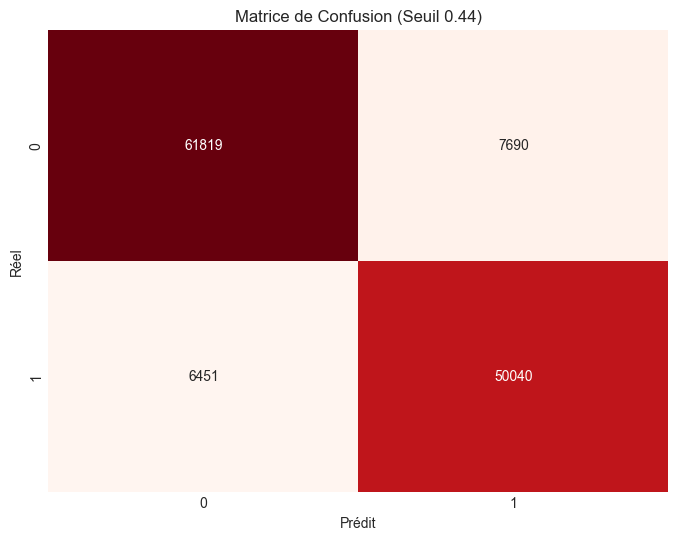

In [5]:
# ==============================================================================
# ÉVALUATION FINALE
# ==============================================================================
y_pred_final = (y_prob >= best_threshold).astype(int)

print("\n--- PERFORMANCE FINALE (Optimisée) ---")
print(classification_report(y_test, y_pred_final))

# Matrice de Confusion
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.title(f'Matrice de Confusion (Seuil {best_threshold:.2f})')
plt.ylabel('Réel')
plt.xlabel('Prédit')
plt.show()


📊 Calcul de l'importance des variables (Méthode Native)...


C:\Users\anase\AppData\Local\Temp\ipykernel_21452\3636786580.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


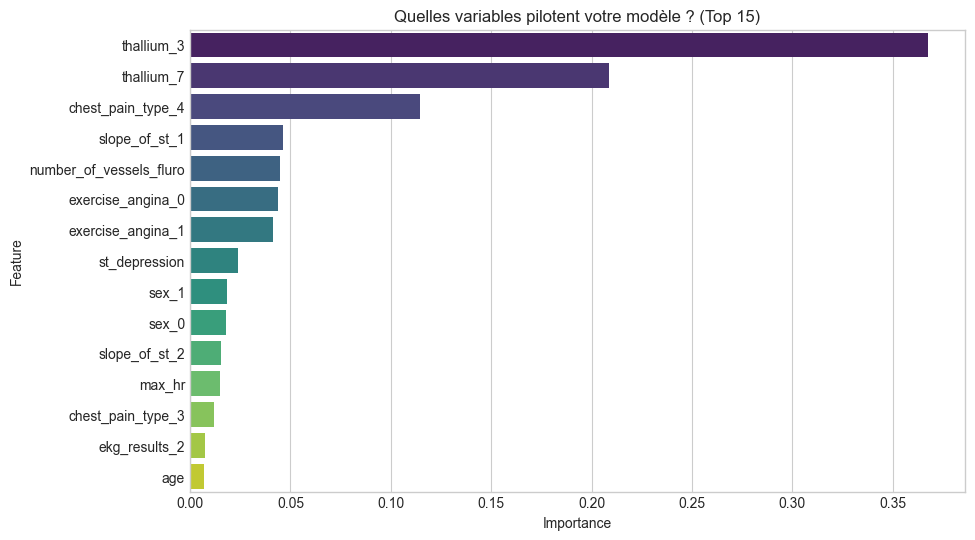

In [6]:
# ==============================================================================
# ALTERNATIVE : Importance des variables (Méthode Native)
# ==============================================================================
import matplotlib.pyplot as plt
import pandas as pd

print("📊 Calcul de l'importance des variables (Méthode Native)...")

# 1. On récupère le modèle entraîné à l'intérieur du Pipeline
xgb_model = model.named_steps['classifier']

# 2. On récupère les noms des colonnes après transformation
# (Même logique que tout à l'heure, mais juste pour l'affichage)
if len(cat_cols) > 0:
    cat_names = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(cat_cols).tolist()
else:
    cat_names = []
feature_names = num_cols + cat_names

# 3. Création d'un DataFrame pour le graphique
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_model.feature_importances_
})

# 4. Tri et Affichage
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(15) # Top 15

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Quelles variables pilotent votre modèle ? (Top 15)')
plt.show()